In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
print("tensorflow: ", tf.__version__)
print("Devices: ", tf.config.list_physical_devices())

tensorflow:  2.19.0
Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [4]:
from tensorflow.keras.datasets import cifar100

(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')
print("train shape: ", x_train.shape)
print("test shape: ", x_test.shape)

train shape:  (50000, 32, 32, 3)
test shape:  (10000, 32, 32, 3)


In [5]:
x_train = x_train.astype("float32")/255.0
x_test = x_test.astype("float32")/255.0

In [6]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(5000)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.prefetch(AUTOTUNE)



In [7]:
#CHECK

for images, labels in train_ds.take(1):
    print(images.shape, labels.shape)

(32, 32, 32, 3) (32, 1)


In [8]:
# DATA AUGMENTATION

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1)
    ],name= "data_augmentation"
)

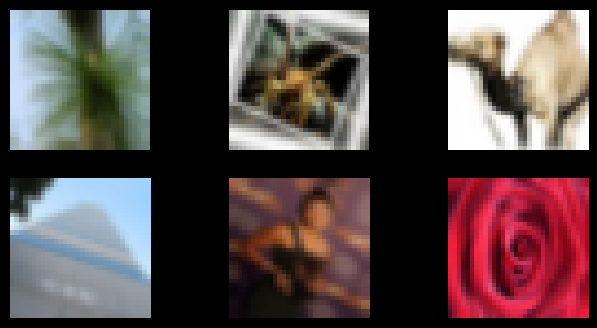

In [9]:
for images,labels in train_ds.take(1):
    augmented_images = data_augmentation(images)

plt.figure(figsize=(8,4))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.show()

In [19]:
def residual_block(inputs, filters, downsample=False):
    """
    Basic Residual block using Functional API

    Args:
    inputs: input tensor
    filters : number of filters
    downsample: whether to downsample spatially

    Returns:
    Output tensor
    """
    stride = 2 if downsample else 1

    # main block

    x = tf.keras.layers.Conv2D(filters, kernel_size=3, strides= stride, padding="same",use_bias=False)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)


    x = tf.keras.layers.Conv2D(filters, kernel_size=3, strides= 1, padding="same",use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Shortcut path
    shortcut = inputs
    if downsample or inputs.shape[-1] != filters:
        shortcut = tf.keras.layers.Conv2D(filters,kernel_size=1,strides=stride,padding='same',use_bias=False)(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    # Addition and activation
    x  = tf.keras.layers.Add()([x,shortcut])
    x = tf.keras.layers.ReLU()(x)

    return x

In [20]:
def build_arvinet_backbone(input_shape=(32,32,3)):
    """
    Custom CNN backbone trained from scratch
    Returns feature vector (no classifier head)

    """
    inputs = tf.keras.Input(shape=input_shape, name = 'input_image')

    x = data_augmentation(inputs)

    x  = tf.keras.layers.Conv2D(
        64,kernel_size=3,strides=1,padding='same',use_bias=False,name='stem_conv')(x)
    x = tf.keras.layers.BatchNormalization(name='stem_bn')(x)
    x = tf.keras.layers.ReLU(name ='stem_relu')(x)

    # -- stage 1 -- #
    x = residual_block(x, filters=64, downsample=False)
    x = residual_block(x, filters=64, downsample=False)

    # -- stage 2 --#
    x = residual_block(x, filters=128, downsample=True)
    x = residual_block(x, filters=128, downsample=False)

    #-- stage 3 --#
    x = residual_block(x, filters=256, downsample=True)
    x = residual_block(x, filters=256, downsample=False)

    #-- stage 4--#
    x = residual_block(x, filters=512, downsample=True)
    x = residual_block(x, filters=512, downsample=False)

    #-- Global Pooling -- #
    x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool')(x)

    model = tf.keras.Model(inputs,x, name='ArviNet_Backbone')
    return model

In [21]:
backbone = build_arvinet_backbone()
backbone.summary()

Model: "ArviNet_Backbone"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 32, 32, 3) │          0 │ input_image[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 32, 32,    │      1,728 │ data_augmentatio… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 32, 32,    │        256 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_relu (ReLU)    │ (None, 32, 32,    │          0 │ stem_bn[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 32, 32,    │     36,864 │ stem_relu[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_15 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 32, 32,    │     36,864 │ re_lu_15[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ stem_relu[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_16 (ReLU)     │ (None, 32, 32,    │          0 │ add_8[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 32, 32,    │     36,864 │ re_lu_16[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_17 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │     36,864 │ re_lu_17[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_23[0][0] 

 Total params: 11,178,432 (42.64 MB)

 Trainable params: 11,168,832 (42.61 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [22]:
backbone = build_arvinet_backbone(input_shape=(32,32,3))

x = backbone.output
outputs = tf.keras.layers.Dense(
    100,activation='softmax',name='cifar100_classifier'
)(x)

model = tf.keras.Model(
    inputs=backbone.input,
    outputs=outputs,
    name='arviNET-Cifar100'
)

In [23]:
model.summary()

Model: "arviNET-Cifar100"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 32, 32, 3) │          0 │ input_image[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 32, 32,    │      1,728 │ data_augmentatio… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 32, 32,    │        256 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_relu (ReLU)    │ (None, 32, 32,    │          0 │ stem_bn[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 32, 32,    │     36,864 │ stem_relu[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_31 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 32, 32,    │     36,864 │ re_lu_31[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ stem_relu[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_32 (ReLU)     │ (None, 32, 32,    │          0 │ add_16[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 32, 32,    │     36,864 │ re_lu_32[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_33 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 32, 32,    │     36,864 │ re_lu_33[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_42[0][0] 

 Total params: 11,229,732 (42.84 MB)

 Trainable params: 11,220,132 (42.80 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics =['accuracy']
)


In [25]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "arvinet_cifar100_best.keras",
        monitor='val_accuracy',
        save_best_only=True,
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=1,
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
    )
]

In [26]:
history = model.fit(
    train_ds,validation_data=test_ds,
    epochs=100,verbose=2,callbacks=callbacks,
)

Epoch 1/100
1563/1563 - 608s - 389ms/step - accuracy: 0.1438 - loss: 3.6693 - val_accuracy: 0.1453 - val_loss: 3.8556 - learning_rate: 0.0010
Epoch 2/100
1563/1563 - 810s - 518ms/step - accuracy: 0.2743 - loss: 2.8837 - val_accuracy: 0.3155 - val_loss: 2.7282 - learning_rate: 0.0010
Epoch 3/100
1563/1563 - 705s - 451ms/step - accuracy: 0.3650 - loss: 2.4428 - val_accuracy: 0.3528 - val_loss: 2.5578 - learning_rate: 0.0010
Epoch 4/100
1563/1563 - 591s - 378ms/step - accuracy: 0.4289 - loss: 2.1339 - val_accuracy: 0.4121 - val_loss: 2.2834 - learning_rate: 0.0010
Epoch 5/100
1563/1563 - 618s - 395ms/step - accuracy: 0.4804 - loss: 1.9028 - val_accuracy: 0.4563 - val_loss: 2.0319 - learning_rate: 0.0010
Epoch 6/100
1563/1563 - 763s - 488ms/step - accuracy: 0.5248 - loss: 1.7236 - val_accuracy: 0.4965 - val_loss: 1.9090 - learning_rate: 0.0010
Epoch 7/100
1563/1563 - 731s - 467ms/step - accuracy: 0.5633 - loss: 1.5626 - val_accuracy: 0.5040 - val_loss: 1.8714 - learning_rate: 0.0010
Epoch 

In [29]:
backbone.save("arvinet_pretrained_backbone.keras")

In [1]:
import tensorflow as tf
backbone = tf.keras.models.load_model("arvinet_pretrained_backbone.keras")
backbone.summary()

Model: "ArviNet_Backbone"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 32, 32, 3) │          0 │ input_image[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 32, 32,    │      1,728 │ data_augmentatio… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 32, 32,    │        256 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_relu (ReLU)    │ (None, 32, 32,    │          0 │ stem_bn[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 32, 32,    │     36,864 │ stem_relu[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_31 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 32, 32,    │     36,864 │ re_lu_31[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ stem_relu[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_32 (ReLU)     │ (None, 32, 32,    │          0 │ add_16[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 32, 32,    │     36,864 │ re_lu_32[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_33 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 32, 32,    │     36,864 │ re_lu_33[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_42[0][0] 

 Total params: 11,178,432 (42.64 MB)

 Trainable params: 11,168,832 (42.61 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [31]:
new = tf.keras.models.load_model("arvinet_cifar100_best.keras")
new.summary()

Model: "arviNET-Cifar100"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 32, 32, 3) │          0 │ input_image[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 32, 32,    │      1,728 │ data_augmentatio… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 32, 32,    │        256 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_relu (ReLU)    │ (None, 32, 32,    │          0 │ stem_bn[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 32, 32,    │     36,864 │ stem_relu[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_31 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 32, 32,    │     36,864 │ re_lu_31[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ stem_relu[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_32 (ReLU)     │ (None, 32, 32,    │          0 │ add_16[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 32, 32,    │     36,864 │ re_lu_32[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_33 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 32, 32,    │     36,864 │ re_lu_33[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_42[0][0] 

 Total params: 33,669,998 (128.44 MB)

 Trainable params: 11,220,132 (42.80 MB)

 Non-trainable params: 9,600 (37.50 KB)

 Optimizer params: 22,440,266 (85.60 MB)

In [2]:
backbone.save_weights("arvinet_pretrained.weights.h5")